#### Sentiment Analysis on Women Closthing Reviews RNN using Keras
Project resource is from Mount San Antonio College, Class: CISD62, Professor: Angel Hernandez,

In [11]:
# data / visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# nlp libraries
import re
import string
from string import punctuation
import nltk
from nltk.corpus import stopwords   # to get collection of stopwords
nltk.download('stopwords') # download stopwords

# ml libraries
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer  # to encode text to int
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.callbacks import ModelCheckpoint   # save model
from tensorflow.keras.models import load_model   # load saved model

data = pd.read_csv("data\women_clothing_review.csv")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gumo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
data.tail()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
23481,23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses
23485,23485,1104,52,Please make more like this one!,This dress in a lovely platinum is feminine an...,5,1,22,General Petite,Dresses,Dresses


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [14]:
# drop coloumns
data = data.drop(columns=["Unnamed: 0", "Title", "Positive Feedback Count"], axis=1)
data.dropna(inplace=True)

In [15]:
data.head()

,Clothing ID,Age,Review Text,Rating,Recommended IND,Division Name,Department Name,Class Name
0,767,33,Absolutely wonderful - silky and sexy and comf...,4,1,Initmates,Intimate,Intimates
1,1080,34,Love this dress! it's sooo pretty. i happene...,5,1,General,Dresses,Dresses
2,1077,60,I had such high hopes for this dress and reall...,3,0,General,Dresses,Dresses
3,1049,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,General Petite,Bottoms,Pants
4,847,47,This shirt is very flattering to all due to th...,5,1,General,Tops,Blouses


In [16]:
data['Polarity_Rating'] = data['Rating'].apply(lambda x: 'Positive' if x > 3 else 'Negative')

<AxesSubplot:xlabel='Rating', ylabel='count'>

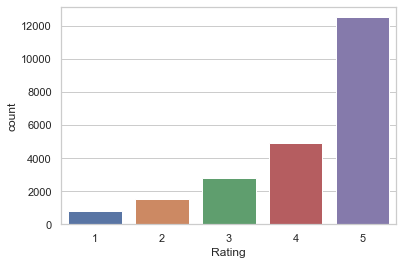

In [17]:
# countplot of ratings
sns.set_theme(style="whitegrid")
sns.countplot(x=data.Rating)

<AxesSubplot:xlabel='Polarity_Rating', ylabel='count'>

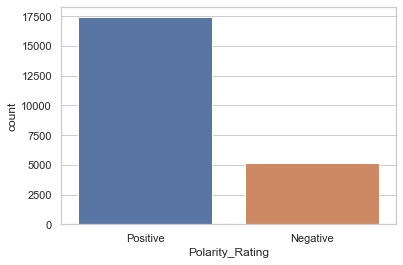

In [18]:
#countplot ploarity
sns.countplot(x=data.Polarity_Rating)

In [19]:
data_Positive = data[data['Polarity_Rating'] == 'Positive'][0:8000]
data_Negative = data[data['Polarity_Rating'] == 'Negative']

In [20]:
# since we dont have enough data for "Negative",
#  we produce more "Negative" to meet the 8000 sample size by copy paste them

data_Negative_over = data_Negative.sample(8000, replace=True)
data = pd.concat([data_Positive, data_Negative_over], axis=0)

In [21]:
# removing stop words
def get_text_processing(text):
    stpword = stopwords.words('english')
    
    # remove the word not from stop word
    stpword.remove('not') 
    no_punctuation = [char for char in text if char not in string.punctuation]
    no_punctuation = ''.join(no_punctuation)
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in stpword])

In [22]:
# remove stop wrod in review
data['review'] = data['Review Text'].apply(get_text_processing)

In [23]:
data.head()

,Clothing ID,Age,Review Text,Rating,Recommended IND,Division Name,Department Name,Class Name,Polarity_Rating,review
0,767,33,Absolutely wonderful - silky and sexy and comf...,4,1,Initmates,Intimate,Intimates,Positive,Absolutely wonderful silky sexy comfortable
1,1080,34,Love this dress! it's sooo pretty. i happene...,5,1,General,Dresses,Dresses,Positive,Love dress sooo pretty happened find store im ...
3,1049,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,General Petite,Bottoms,Pants,Positive,love love love jumpsuit fun flirty fabulous ev...
4,847,47,This shirt is very flattering to all due to th...,5,1,General,Tops,Blouses,Positive,shirt flattering due adjustable front tie perf...
6,858,39,I aded this in my basket at hte last mintue to...,5,1,General Petite,Tops,Knits,Positive,aded basket hte last mintue see would look lik...


In [24]:
data = data[['review', 'Polarity_Rating']]

In [25]:
data.head()

,review,Polarity_Rating
0,Absolutely wonderful silky sexy comfortable,Positive
1,Love dress sooo pretty happened find store im ...,Positive
3,love love love jumpsuit fun flirty fabulous ev...,Positive
4,shirt flattering due adjustable front tie perf...,Positive
6,aded basket hte last mintue see would look lik...,Positive


In [26]:
english_stops = set(stopwords.words('english'))
english_stops.remove('not')

In [27]:
def load_dataset(txt):
    #df = pd.read_csv('IMDB Dataset.csv')
    df = txt
    x_data = df['review']       # Reviews/Input
    y_data = df['Polarity_Rating']    # Sentiment/Output

    # PRE-PROCESS REVIEW
    x_data = x_data.replace({'<.*?>': ''}, regex = True)          # remove html tag
    x_data = x_data.replace({'[^A-Za-z]': ' '}, regex = True)     # remove non alphabet
    x_data = x_data.apply(lambda review: [w for w in review.split() if w not in english_stops])  # remove stop words
    x_data = x_data.apply(lambda review: [w.lower() for w in review])   # lower case
    
    # ENCODE SENTIMENT -> 0 & 1
    y_data = y_data.replace('Positive', 1)
    y_data = y_data.replace('Negative', 0)


    return x_data, y_data

In [28]:
x_data, y_data = load_dataset(data)
print('Reviews')
print(x_data, '\n')
print('Sentiment')
print(y_data)

Reviews
0        [absolutely, wonderful, silky, sexy, comfortable]
1        [love, dress, sooo, pretty, happened, find, st...
3        [love, love, love, jumpsuit, fun, flirty, fabu...
4        [shirt, flattering, due, adjustable, front, ti...
6        [aded, basket, hte, last, mintue, see, would, ...
                               ...                        
11381    [vest, nice, fashionable, stylish, like, lot, ...
5697     [love, cold, shoulder, trend, top, seemed, sat...
19340    [skirt, fits, strange, way, one, pleated, area...
5072     [top, really, cute, threads, underneath, shirt...
7773     [super, cute, colors, vibrant, thin, enough, w...
Name: review, Length: 16000, dtype: object 

Sentiment
0        1
1        1
3        1
4        1
6        1
        ..
11381    0
5697     0
19340    0
5072     0
7773     0
Name: Polarity_Rating, Length: 16000, dtype: int64


In [29]:
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)


In [30]:
print(X_train)
print(X_test)
print(y_train)
print(y_test)


923      [really, loved, soft, snuggly, unsure, orderin...
3759     [dress, runs, large, lbs, hourglass, curvy, bu...
9495                    [dress, pretty, neckline, darling]
16491    [beautifully, made, shirt, however, sizing, wa...
15758    [large, looked, awful, huge, armholes, baggy, ...
                               ...                        
2874     [order, retailer, regularly, pretty, consisten...
7179     [really, wanted, love, dress, like, lacing, ne...
1169     [although, may, not, look, like, takes, shape,...
17322    [pants, fit, tts, ask, pictured, length, go, t...
9781     [got, teal, color, beautiful, get, many, compl...
Name: review, Length: 12800, dtype: object
4096     [well, disappointed, fabric, dress, heavier, m...
6246     [love, bulging, substantive, fabric, flatterin...
8143     [bought, whim, gift, mom, fit, perfectly, love...
413      [got, green, color, gray, accent, stitching, l...
11803    [saw, dress, online, thought, perfectly, cute,...
             

In [31]:
# Max length of review
def get_max_length():
    review_length = []
    for review in X_train:
        review_length.append(len(review))

    return int(np.ceil(np.mean(review_length)))

In [32]:
max_length = get_max_length()
print(max_length)

30


In [33]:
# ENCODE REVIEW
token = Tokenizer(lower=False)    # False becuase we already did it. 

# find formula to vectorize the text
token.fit_on_texts(X_train)

# converting text into integer
x_train = token.texts_to_sequences(X_train)
x_test = token.texts_to_sequences(X_test)

### this is the code to add the pad to x_train
x_train = pad_sequences(x_train, maxlen=max_length, padding='post', truncating='post')

############# add pad to x_test   ########################### 
x_test = pad_sequences(x_test, maxlen=max_length, padding='post', truncating='post')

total_words = len(token.word_index) + 1   # we need to add 1 because of 0 padding

In [34]:
print(x_train)
print(x_test)
print(max_length)

[[  16   81   33 ...    0    0    0]
 [   2   80   26 ...    8  418    7]
 [   2   45  223 ...    0    0    0]
 ...
 [ 346  176    1 ...    0    0    0]
 [  71    7  261 ...   43   93  233]
 [  50 1412   15 ...    0    0    0]]
[[  30  121   11 ...    0    0    0]
 [   6 6927   11 ... 1777   11 4173]
 [  36 1202 1228 ...    0    0    0]
 ...
 [ 354  130  314 ...  367  134  262]
 [ 100  139   74 ...   50   59    1]
 [  37   45   54 ...    0    0    0]]
30


In [35]:
# ARCHITECTURE
EMBED_DIM = 32
LSTM_OUT = 64

#### add the model here:
model = Sequential()
model.add(Embedding(input_dim=total_words, output_dim=128,
                  input_length=max_length))

# dropout and recurrent dropout
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=1, activation='sigmoid'))

### compile the model using: optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 128)           1522944   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,654,657
Trainable params: 1,654,657
Non-trainable params: 0
_________________________________________________________________


In [37]:
# Save model checkpoint and save best only
checkpoint = ModelCheckpoint('models/LSTM.h5', monitor='accuracy', save_best_only=True, verbose=1)

In [38]:
# fit and train model, call back based on checkpoint(best model)
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test), callbacks=[checkpoint])

Epoch 1/10
400/400 [==============================] - ETA: 0s - loss: 0.4133 - accuracy: 0.8126
Epoch 1: accuracy improved from -inf to 0.81258, saving model to models\LSTM.h5
400/400 [==============================] - 19s 42ms/step - loss: 0.4133 - accuracy: 0.8126 - val_loss: 0.3370 - val_accuracy: 0.8669
Epoch 2/10
400/400 [==============================] - ETA: 0s - loss: 0.2527 - accuracy: 0.9052
Epoch 2: accuracy improved from 0.81258 to 0.90523, saving model to models\LSTM.h5
400/400 [==============================] - 20s 50ms/step - loss: 0.2527 - accuracy: 0.9052 - val_loss: 0.3176 - val_accuracy: 0.8744
Epoch 3/10
399/400 [============================>.] - ETA: 0s - loss: 0.1802 - accuracy: 0.9354
Epoch 3: accuracy improved from 0.90523 to 0.93547, saving model to models\LSTM.h5
400/400 [==============================] - 19s 48ms/step - loss: 0.1801 - accuracy: 0.9355 - val_loss: 0.4249 - val_accuracy: 0.8716
Epoch 4/10
400/400 [==============================] - ETA: 0s - los

In [39]:
# Load the best model saved
loaded_model = tf.keras.models.load_model('models/LSTM.h5')

In [40]:
review = str(input('Clothing review: '))

In [41]:
# Pre-process input
regex = re.compile(r'[^a-zA-Z\s]')
review = regex.sub('', review)
print('Cleaned: ', review)

# remove stop word for input
words = review.split(' ')
filtered = [w for w in words if w not in english_stops]
filtered = ' '.join(filtered)
filtered = [filtered.lower()]

print('Filtered: ', filtered)

Cleaned:  
Filtered:  ['']


In [42]:
# tokenize the filtered word
tokenize_words = token.texts_to_sequences(filtered)

# apply padding
tokenize_words = pad_sequences(tokenize_words, maxlen=max_length, padding='post', truncating='post')
print(tokenize_words)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [43]:
# use the best model to predict
result = loaded_model.predict(tokenize_words)
print(result)

[[0.69847417]]


In [44]:
# Note the result is 0 to 1
if result < 0.5:
    print('negative')
else:
    print('postive')

postive
